<div style="text-align:center">
    <h1><b>KLASIFIKASI IKAN SEHAT DENGAN IKAN TERINFEKSI PENYAKIT BERDASARKAN CITRA KULITNYA</b></h1>
    <h1><b></b></h1>
</div>
<br><br>
<br><br>
<table style="width:100%;">
    <tr>
        <td align="center">
            <img src="UNRAM-LOGO.png" alt="Foto" width="500" height="500">
        </td>
    </tr>
</table>
<br><br>
<br><br>
<div style="text-align:center">
    <h2>Disusun Oleh:</h2>
    <h2>MUHAMMAD ADHITYA NUGRAHA: F1D02310016</h2>
    <h2>MUHAMMAD RIDHO AIDIL FURQON: F1D02310127</h2>
    <h2>IRFAN JAYADI: F1D02310011<h2>
    <h2>MUHAMMAD FARUK WIRA PRABUANA JAMALUDIN: F1D02310147</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<div style="text-align:center">
    <h2>UNIVERSITAS MATARAM</h2>
    <h2>FAKULTAS TEKNIK</h2>
    <h2>TEKNIK INFORMATIKA</h2>
    <h2>2024/2025</h2>
</div>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>


## Latar Belakang


In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

DATA LOADING

In [2]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



Data Understanding

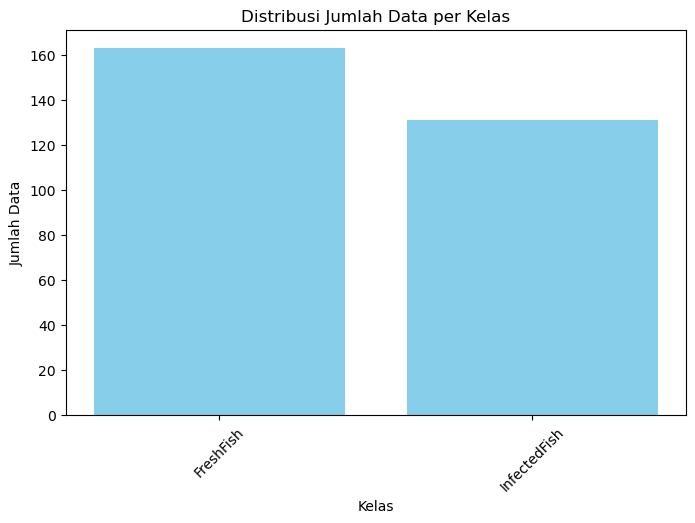

In [3]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

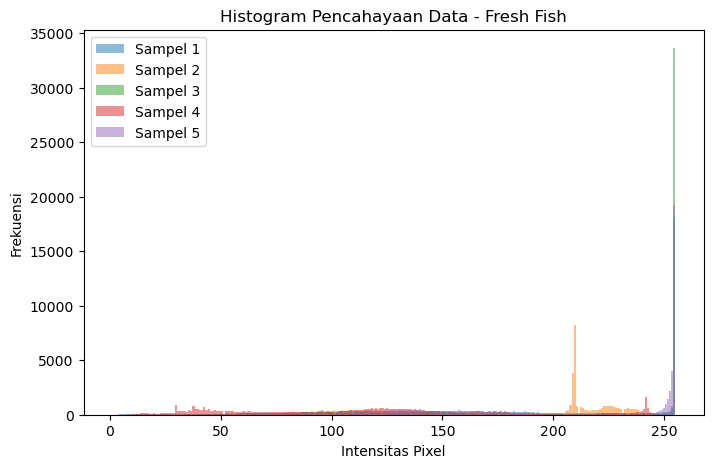

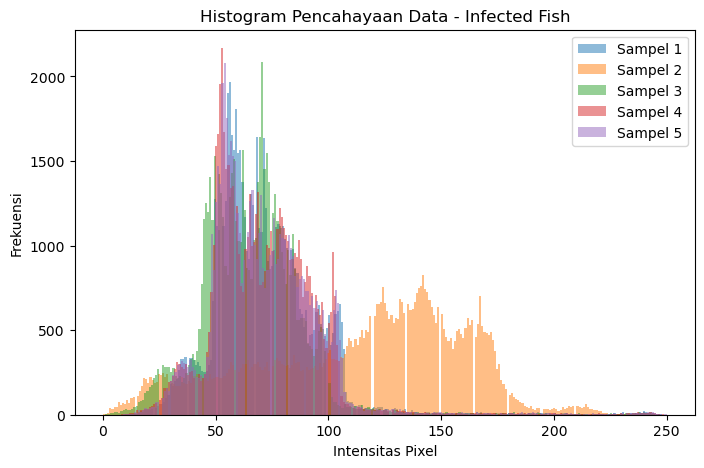

In [4]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

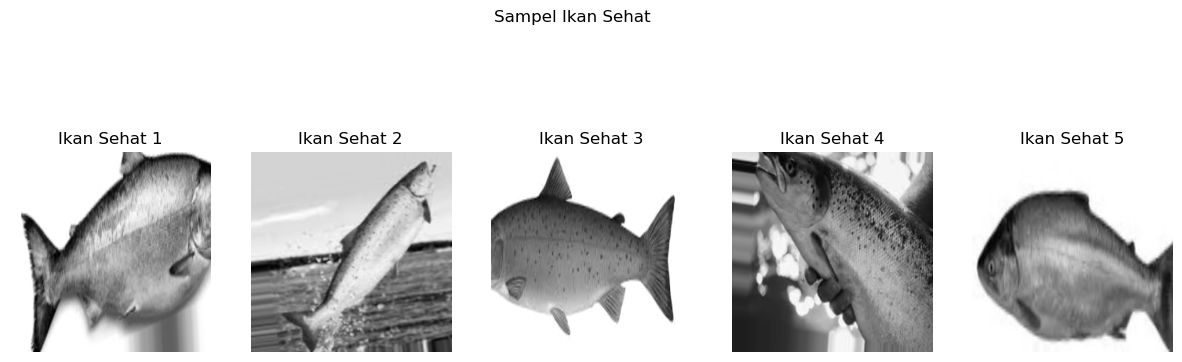

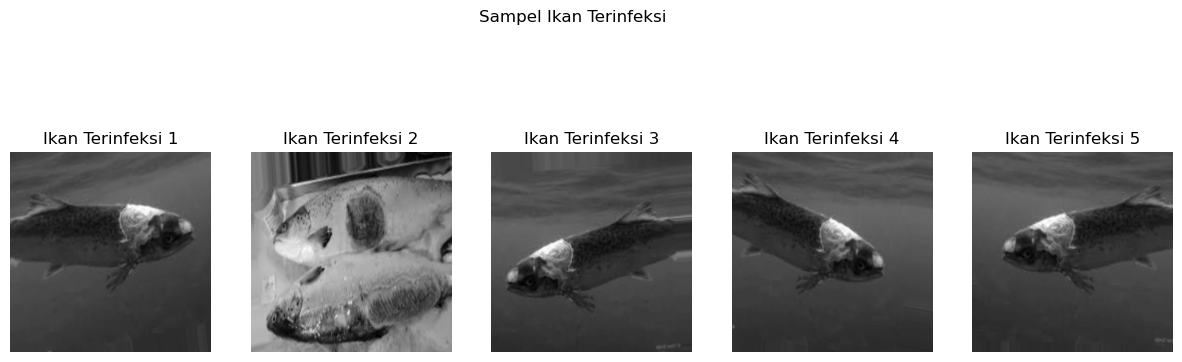

In [5]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

DEFINE DATA AUGMENTATION

In [6]:
augmented = {
    'data': [],
    'labels': [],
    'filenames': []
}

# Proses augmentasi
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    filename = file_name[i]

    # 1. Flip Horizontal
    img_flip_h = cv.flip(img, 1)

    # 2. Flip Vertikal
    img_flip_v = cv.flip(img, 0)

    # 3. Rotasi 90 Derajat
    img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

    # 4. Rotasi 180 Derajat
    img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # 5. Translasi (geser gambar)
    rows, cols = img.shape[:2]
    M = np.float32([[1, 0, 20], [0, 1, 20]])  # Geser 20 piksel kanan & bawah
    img_translated = cv.warpAffine(img, M, (cols, rows))

    # Simpan semua hasil ke dalam dictionary 'augmented'
    augmented_images = [
        (img_flip_h, 'flip_h'),
        (img_flip_v, 'flip_v'),
        (img_rot_90, 'rot_90'),
        (img_rot_180, 'rot_180'),
        (img_translated, 'translated')
    ]

    for img_aug, suffix in augmented_images:
        augmented['data'].append(img_aug)
        augmented['labels'].append(label)
        augmented['filenames'].append(f"{filename}_{suffix}")

# Tampilkan hasil
print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(augmented['data']))

Jumlah data sebelum augmentasi: 294
Jumlah data setelah augmentasi: 1470


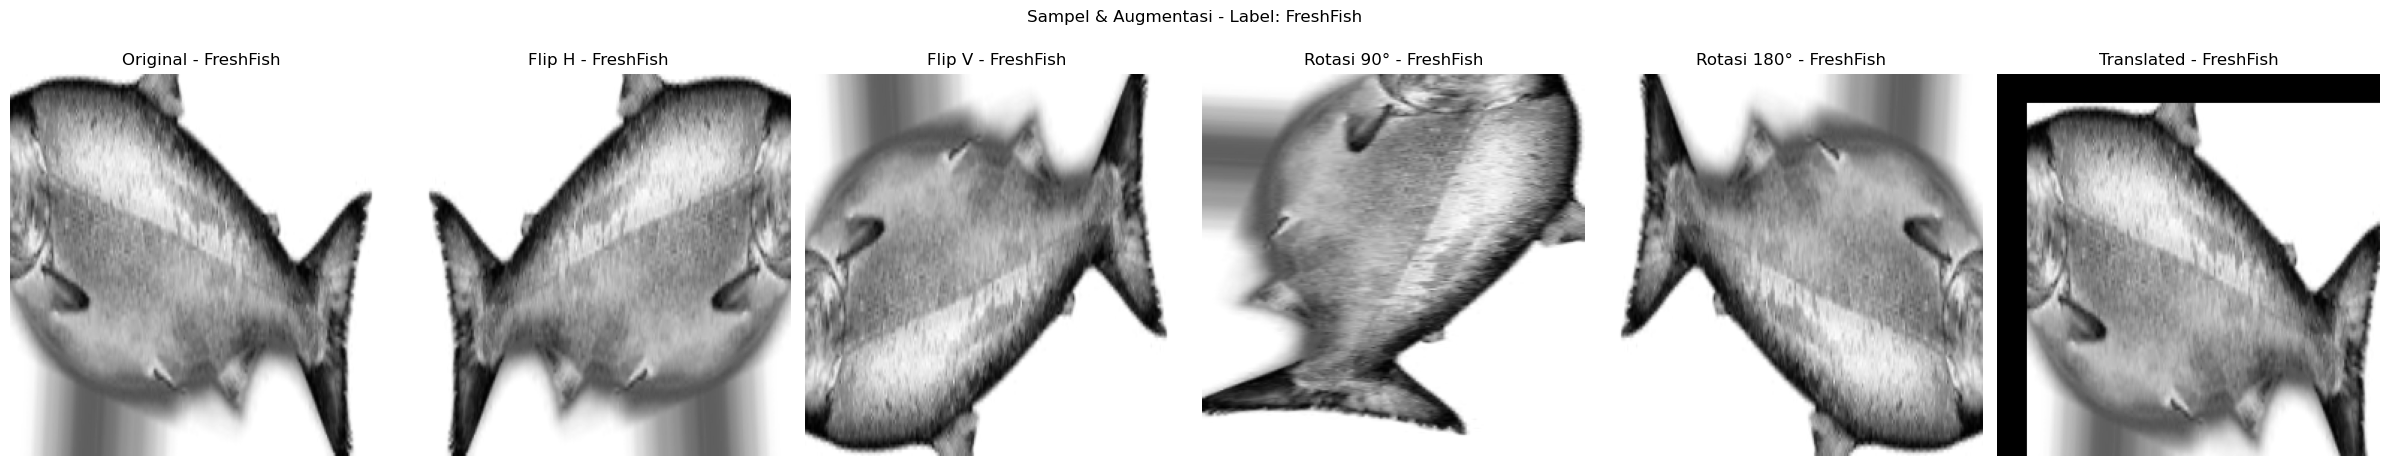

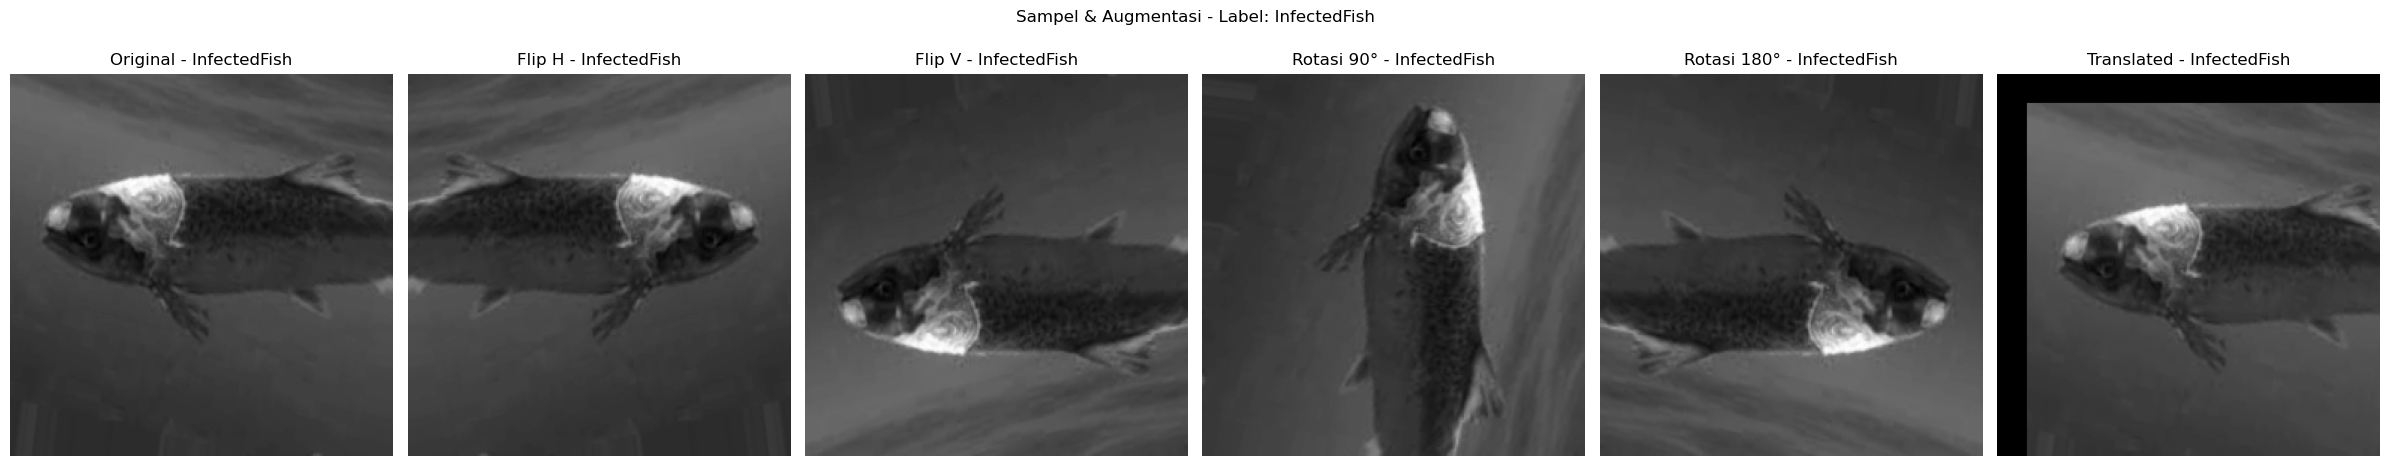

In [7]:
# Ambil label unik dari data yang telah di-augmentasi
unique_labels = np.unique(augmented['labels'])

for label in unique_labels:
    # Ambil semua gambar yang label-nya sama
    samples = [augmented['data'][i] for i in range(len(augmented['labels'])) if augmented['labels'][i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Ambil satu contoh gambar

        # Translasi tambahan
        rows, cols = sample_img.shape[:2]
        M_trans = np.float32([[1, 0, 20], [0, 1, 20]])
        img_translated = cv.warpAffine(sample_img, M_trans, (cols, rows))

        # Siapkan tampilan
        fig, axes = plt.subplots(1, 6, figsize=(24, 5))
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°", "Translated"]

        # Daftar gambar hasil augmentasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),
            cv.flip(sample_img, 0),
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),
            cv.rotate(sample_img, cv.ROTATE_180),
            img_translated
        ]

        # Tampilkan semua hasil dalam satu baris
        for i in range(6):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")

        plt.suptitle(f"Sampel & Augmentasi - Label: {label}")
        plt.tight_layout()
        plt.show()

PREPROSSESING

In [ ]:
def normalize(img):
    img = img.astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    norm_img = (img - min_val) / (max_val - min_val) * 255
    return norm_img.astype(np.uint8)

def histogram_equalization(img):
    # Histogram Equalization secara manual
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    cdf_max = cdf_masked.max()
    cdf_masked = (cdf_masked - cdf_min) * 255 / (cdf_max - cdf_min)
    cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')
    img_eq = cdf_final[img]
    return img_eq


In [9]:
def prepro1(img):
    norm = normalize(img)
    eq = histogram_equalization(norm)
    return eq

In [10]:
# Inisialisasi list untuk menyimpan hasil preprocessing
dataPreprocessed_1 = []

# Ambil data hasil augmentasi
augmented_data = augmented['data']

# Lakukan preprocessing untuk masing-masing percobaan
for img in augmented_data:
    dataPreprocessed_1.append(prepro1(img))
dataPreprocessed = dataPreprocessed_1


FEATURE EXTRACTION

In [11]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [12]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [13]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [14]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [15]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [16]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [17]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [18]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [19]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [20]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [21]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [22]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [23]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [24]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [25]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [26]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [27]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Write the extraction's results to CSV

In [28]:
dataTable = {'Filename': augmented['filenames'], 'Label': augmented['labels'],
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png_flip_h,FreshFish,249.001547,289.392480,103.422013,326.162983,0.394014,0.379924,0.481342,0.368360,...,0.074072,0.070304,0.267795,0.265482,0.272161,0.265148,0.983049,0.980269,0.992961,0.977762
1,aug_0_1014.png_flip_v,FreshFish,249.001547,289.392480,103.422013,326.162983,0.394014,0.379924,0.481342,0.368360,...,0.074072,0.070304,0.267795,0.265482,0.272161,0.265148,0.983049,0.980269,0.992961,0.977762
2,aug_0_1014.png_rot_90,FreshFish,103.422013,289.392480,249.001547,326.162983,0.481342,0.379924,0.394014,0.368360,...,0.071714,0.070304,0.272161,0.265482,0.267795,0.265148,0.992961,0.980269,0.983049,0.977762
3,aug_0_1014.png_rot_180,FreshFish,249.001547,326.162983,103.422013,289.392480,0.394014,0.368360,0.481342,0.379924,...,0.074072,0.070481,0.267795,0.265148,0.272161,0.265482,0.983049,0.977762,0.992961,0.980269
4,aug_0_1014.png_translated,FreshFish,449.236137,717.458900,285.965901,678.885982,0.478098,0.452659,0.535804,0.462689,...,0.076176,0.072878,0.273027,0.269488,0.276000,0.269958,0.974082,0.958562,0.983484,0.960790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,aug_0_9876.png_flip_h,InfectedFish,115.429917,554.375548,473.118581,484.096163,0.431307,0.298332,0.318000,0.311693,...,0.019597,0.019238,0.147380,0.136992,0.139990,0.138703,0.990409,0.953840,0.960733,0.959692
1466,aug_0_9876.png_flip_v,InfectedFish,115.429917,554.375548,473.118581,484.096163,0.431307,0.298332,0.318000,0.311693,...,0.019597,0.019238,0.147380,0.136992,0.139990,0.138703,0.990409,0.953840,0.960733,0.959692
1467,aug_0_9876.png_rot_90,InfectedFish,473.118581,554.375548,115.429917,484.096163,0.318000,0.298332,0.431307,0.311693,...,0.021721,0.019238,0.139990,0.136992,0.147380,0.138703,0.960733,0.953840,0.990409,0.959692
1468,aug_0_9876.png_rot_180,InfectedFish,115.429917,484.096163,473.118581,554.375548,0.431307,0.311693,0.318000,0.298332,...,0.019597,0.018767,0.147380,0.138703,0.139990,0.136992,0.990409,0.959692,0.960733,0.953840


<Axes: >

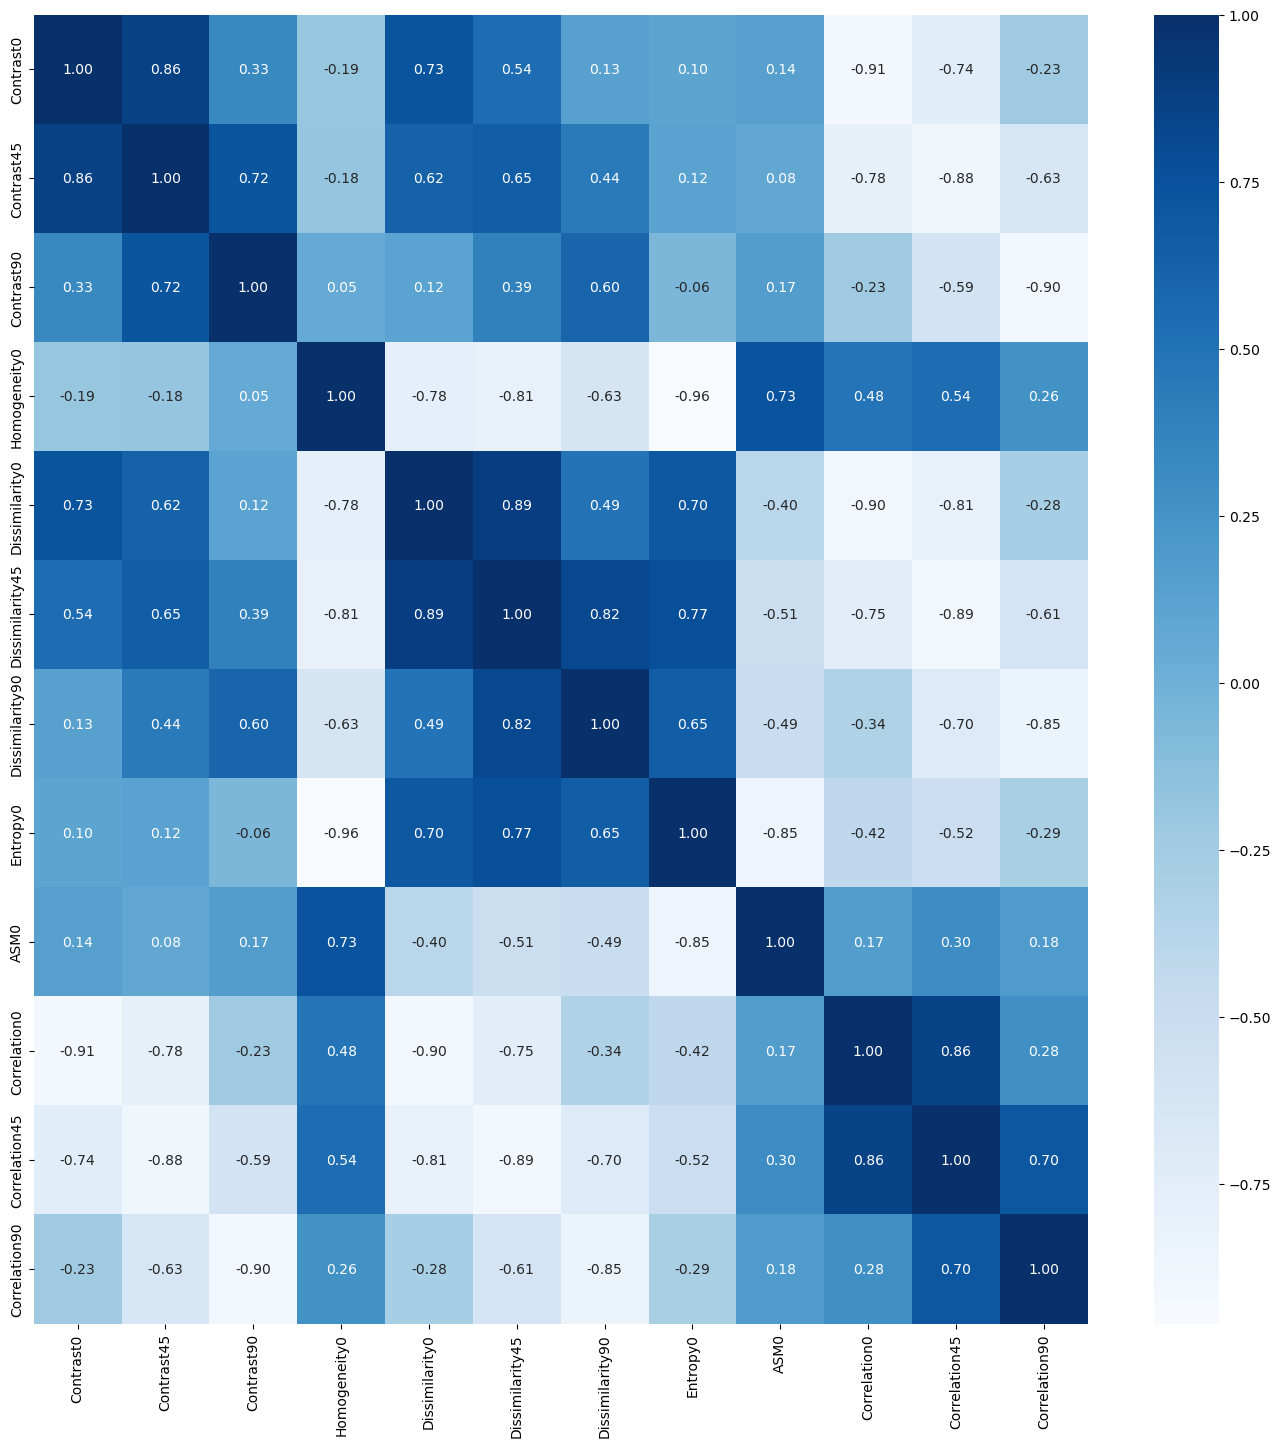

In [29]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Splitting Data

In [30]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(1176, 12)
(294, 12)


Feature Normalization

In [31]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Modeling
Define Model

In [32]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Train Random Forest Classifier

In [33]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       1.00      0.99      1.00       654
InfectedFish       0.99      1.00      1.00       522

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

[[649   5]
 [  0 522]]
Accuracy: 0.9957482993197279

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.96      0.97      0.96       161
InfectedFish       0.96      0.95      0.95       133

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294

[[156   5]
 [  7 126]]
Accuracy: 0.9591836734693877


Train SVM Classifier

In [34]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.90      0.85      0.88       654
InfectedFish       0.83      0.88      0.85       522

    accuracy                           0.87      1176
   macro avg       0.86      0.87      0.86      1176
weighted avg       0.87      0.87      0.87      1176

[[558  96]
 [ 62 460]]
Accuracy: 0.8656462585034014

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.90      0.87      0.89       161
InfectedFish       0.85      0.89      0.87       133

    accuracy                           0.88       294
   macro avg       0.88      0.88      0.88       294
weighted avg       0.88      0.88      0.88       294

[[140  21]
 [ 15 118]]
Accuracy: 0.8775510204081632


Train KNN Classifier

In [35]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.99      0.97      0.98       654
InfectedFish       0.97      0.98      0.98       522

    accuracy                           0.98      1176
   macro avg       0.98      0.98      0.98      1176
weighted avg       0.98      0.98      0.98      1176

[[637  17]
 [  9 513]]
Accuracy: 0.9778911564625851

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.99      0.96      0.97       161
InfectedFish       0.95      0.98      0.97       133

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294

[[154   7]
 [  2 131]]
Accuracy: 0.9693877551020408


Evaluation With Confusion Matrix

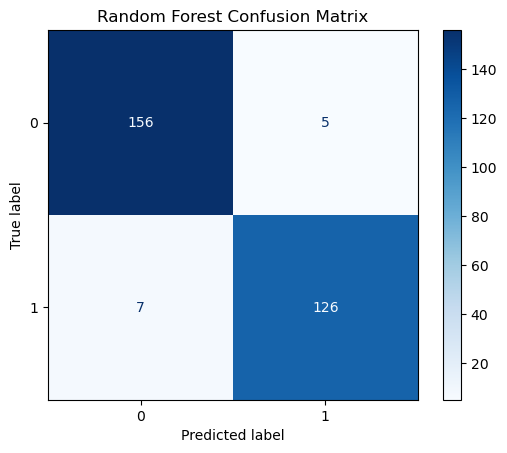

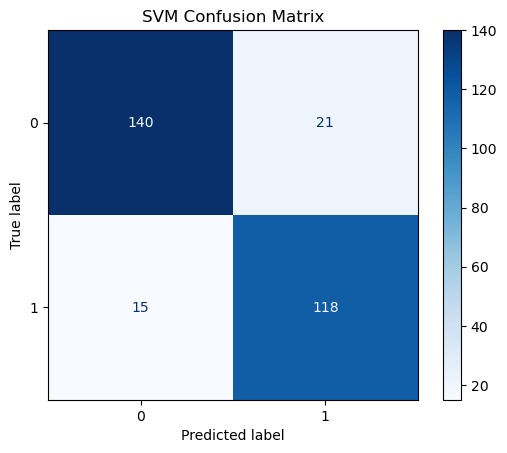

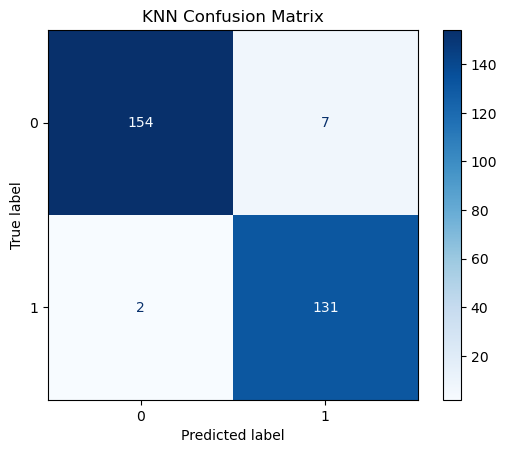

In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")